In [1]:
cd ../../src

/Users/in-divye.singh/Documents/Projects/MIC_predictor/src


In [2]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain, combinations
from collections import Counter

from utils import *

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [3]:
import seaborn as sns

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [5]:
avp_ic50 = pd.read_csv("../data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("../data/raw/HA_AVP.csv")

In [6]:
df = pd.concat([avp_ic50[['Sequence','MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

In [7]:
df

,Sequence,MIC
0,AAQRRGRVGRNPNQVGD,442.00000
1,HRILARIRQMMT,435.50000
2,RNPSQVGD,383.00000
3,RVGRNPNQVGD,374.00000
4,AAQRRGRIGRNPSQVGD,358.00000
...,...,...
707,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515
708,CFPYITRPGTYHDWWYTRKNRQ,0.30000
709,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131
710,GTNLSVPNPLGFFPDHQLDPAFGANSNNPDWDFNPNKDHWPEANKVG,0.00008


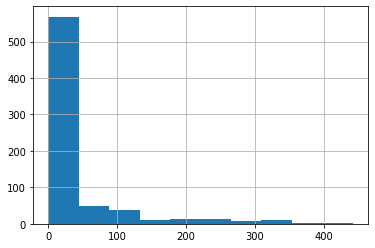

In [8]:
df['MIC'].hist()

In [9]:
df['pIC50'] = df['MIC'].apply(lambda x: -np.log(x*1e-6))

In [10]:
df

,Sequence,MIC,pIC50
0,AAQRRGRVGRNPNQVGD,442.00000,7.724201
1,HRILARIRQMMT,435.50000,7.739016
2,RNPSQVGD,383.00000,7.867476
3,RVGRNPNQVGD,374.00000,7.891255
4,AAQRRGRIGRNPSQVGD,358.00000,7.934978
...,...,...,...
707,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515,15.977030
708,CFPYITRPGTYHDWWYTRKNRQ,0.30000,15.019483
709,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131,18.297579
710,GTNLSVPNPLGFFPDHQLDPAFGANSNNPDWDFNPNKDHWPEANKVG,0.00008,23.248994


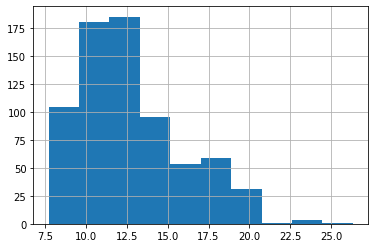

In [11]:
df['pIC50'].hist()

In [12]:
def get_physicochemical_properties(df):
    params = ['aromaticity', 'helix', 'turn', 'sheet', 'gravy', 'net_charge_at_pH7point4']

    prop = []
    for seq in df.Sequence:
        X = ProteinAnalysis(seq)
        aromaticity = X.aromaticity()
        sec_struc = X.secondary_structure_fraction()
        helix = sec_struc[0]
        turn = sec_struc[1]
        sheet = sec_struc[2]
        gravy = X.gravy() # hydrophobicity related
        net_charge_at_pH7point4 = X.charge_at_pH(7.4)

        prop.append([aromaticity, helix, turn, sheet, gravy, net_charge_at_pH7point4])
    return pd.DataFrame(prop, columns=params)

In [13]:
aa_freq = reduce_by_kmer_frequency(df)

In [14]:
uniprot_embedding = biovec.models.load_protvec("../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_protvec = convert_sequences_to_avg_vectors(df['Sequence'], uniprot_embedding, kmer=3)
avg_protvec = avg_protvec.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 712/712 [00:00<00:00, 1159.08sequence/s]


In [15]:
physicochemical_prop = get_physicochemical_properties(df)

In [16]:
X = pd.concat([aa_freq, avg_protvec, physicochemical_prop[['helix','turn','sheet']]], axis=1)

In [17]:
y = df[['pIC50', 'MIC']]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']

In [20]:
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut

In [21]:
def multi_objective_score(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    std_diff = abs(np.std(y_pred) - np.std(y_true))
    return mape + 10*std_diff
multi_objective_scorer = make_scorer(multi_objective_score, greater_is_better=False)

In [22]:
param_grid = {
    'n_estimators':[100,200,300,500,1000,1500,2000,2500,5000],
    'max_depth':[None,2,3,4,5,6,7,8,9,10],
    'max_features':["auto","sqrt","log2"],
    'criterion' : ["mae"]
}
svr = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = svr, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring=multi_objective_scorer)

In [23]:
grid_search.fit(X_train, y_train_mic)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 73.7min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 113.5min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 164.9min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 268.7min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed: 393.5min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mae'],
                         'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 500, 1000, 1500, 2000,
                                          2500, 5000]},
             scoring=make_scorer(multi_objective_score, greater_is_better=False),
             verbose=2)

In [24]:
grid_search.best_params_

{'criterion': 'mae',
 'max_depth': 2,
 'max_features': 'auto',
 'n_estimators': 200}

In [25]:
best_grid = grid_search.best_estimator_

In [26]:
y_pred_mic = best_grid.predict(X_test)

In [27]:
mean_absolute_percentage_error(y_test_mic, y_pred_mic)

1483569.4060987816

In [28]:
np.std(y_test_mic), np.std(y_pred_mic)

(68.39438237006428, 17.370255190674758)

In [ ]:
np.std(y_pred_pmic) - np.std(y_test_pmic)

In [ ]:
multi_objective_score(y_test_pmic,y_pred_pmic)

In [41]:
X_train.shape

(569, 123)

In [127]:
rf = RandomForestRegressor(criterion='mse',max_features=123,n_estimators=200,n_jobs=-1,max_depth=50)
# cv_score = cross_val_score(rf, X_train, y_train_mic, cv=5, scoring=mape_scorer)
# cv_mean = cv_score.mean()
# print(cv_score, cv_mean)

_ = rf.fit(X_train, y_train_pmic)
y_pred = rf.predict(X_test)

print(np.std(y_test_pmic), np.std(y_pred))

3.331777161170943 1.877957986412758


In [128]:
mean_absolute_percentage_error(y_test_pmic,y_pred)

15.488475876406088

In [110]:
import matplotlib.pyplot as plt

(array([29., 39., 32., 16.,  9., 10.,  7.,  0.,  0.,  1.]),
 array([ 7.86747557,  9.71299684, 11.55851811, 13.40403939, 15.24956066,
        17.09508193, 18.94060321, 20.78612448, 22.63164575, 24.47716702,
        26.3226883 ]),
 <a list of 10 Patch objects>)

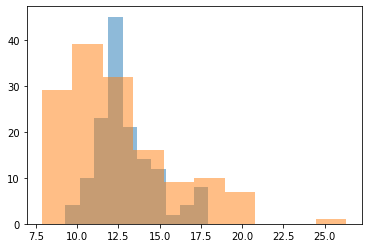

In [103]:
plt.hist(y_pred, alpha=0.5)
plt.hist(y_test_pmic, alpha=0.5)

In [104]:
y_pred.max(), y_test_pmic.max()

(17.954507767891336, 26.32268829627837)

In [129]:
ape = 100*np.abs(y_test_pmic-y_pred)/y_test_pmic

In [130]:
y_pred_mic = np.exp(-y_pred)/1e-6

In [131]:
ape_mic = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic

In [132]:
list(zip(y_test_pmic.round(4), y_pred.round(4), ape, y_test_mic.round(4), y_pred_mic.round(4), ape_mic))

[(14.0512, 13.0782, 6.924658453062215, 0.79, 2.0902, 164.58698742082134),
 (12.557, 12.7014, 1.1494239073778827, 3.52, 3.0469, 13.440117627172667),
 (10.6585, 11.3755, 6.727254789272018, 23.5, 11.4728, 51.179756515530386),
 (11.2506, 14.1688, 25.93887126465783, 13.0, 0.7024, 94.59728502895565),
 (13.1224, 14.8814, 13.404503944105617, 2.0, 0.3444, 82.77808898188161),
 (13.1124, 12.5506, 4.28489477245935, 2.02, 3.5429, 75.3919681311596),
 (10.8198, 12.1662, 12.444363093937836, 20.0, 5.2032, 73.98384502348459),
 (10.7475, 11.528, 7.262690576454606, 21.5, 9.8503, 54.18481465095861),
 (9.2103, 10.8177, 17.451267194769436, 100.0, 20.0424, 79.95761906829395),
 (13.1224, 14.0041, 6.7196546955052305, 2.0, 0.8281, 58.59537129140321),
 (8.7403, 11.8151, 35.17946926116579, 160.0, 7.3918, 95.38013211549693),
 (9.8191, 11.9205, 21.400250174550315, 54.4, 6.6528, 87.77053394029002),
 (9.2103, 10.9694, 19.098797204779522, 100.0, 17.2206, 82.77940663206036),
 (18.7774, 16.7184, 10.965103963367067, 0.007

In [ ]:
ape_mic.mean()

### Leave one out CV

In [ ]:
loo = LeaveOneOut()

In [ ]:
from tqdm import tqdm

In [ ]:
result_df = pd.DataFrame(columns = list(df.columns)+["y_pred_pmic", "y_pred_mic", "ape_pmic", "ape_mic"])
for train_index, test_index in tqdm(loo.split(X)):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
    y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']
    svr = SVR(C=10, gamma=10)
    _ = svr.fit(X_train, y_train_pmic)
    y_pred_pmic = svr.predict(X_test)
    y_pred_mic = np.exp(-y_pred_pmic)/1e-6
    ape = 100*np.abs(y_test_pmic-y_pred_pmic)/y_test_pmic
    ape_mic = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic
    df_val = df.iloc[test_index,:].values[0].tolist()
    res = np.append(df_val, [y_pred_pmic[0], y_pred_mic[0], ape.values[0], ape_mic.values[0]])
    res = pd.DataFrame([res], columns = list(df.columns)+["y_pred_pmic", "y_pred_mic", "ape_pmic", "ape_mic"])
    result_df = result_df.append(res)
result_df = result_df[["Sequence", "pIC50", "y_pred_pmic", "ape_pmic", "MIC", "y_pred_mic", "ape_mic"]]

In [ ]:
result_df#.to_csv("../results/SVM_pMIC_to_MIC_rbf_c_100_gamma_3.csv", index=False)

In [ ]:
result_df['ape_mic'].astype('float').mean()

In [ ]:
sns.relplot(x=y_pred_pmic, y=(y_test_pmic-y_pred_pmic))

In [ ]:
sns.relplot(x=y_pred_mic, y=(y_test_mic-y_pred_mic))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.hist(y_pred_mic, alpha=0.5)
plt.hist(y_test_mic, alpha=0.5)